# Image Captioning with Autoencoders

In this project we aim to caption an image using a combination of autoencoders and SVM. For this purpose we use a subset of the captioned MS-COCO dataset for training. This is achieved in three board stages:
### A. Feature Extraction with Autoencoder
- In this stage we use a Convolutional Autoencoder to compress the images  into a smaller feature space.
- The autoencoder minimizes the original image (200px x 200px RGB) into a smaller feature space.
- It also minimizes the loss by reconstucting an image from the smaller feature space and applying gradient descent to readjust weights.

### B. Label Prediction with SVM trained on Autoencoder Features
- Once the autoencoder has been trained, the new features are extracted for the training and test set.
- An SVM model is then trained with the training data features and label predicions are made to determine the category of the test images.

### C. Caption Prediction using the Nearest Neighbors Algorithm
- Lastly, the nearest neighbors algorithms is used to find the K=5 nearest images within the predicted class.
- The most appropriate caption is determined from the captions of the 5 nearest neighbors identified within the class. Its done using semantic similarity analysis among the captions.

In [194]:
import re
import os
import cv2
import json
import time
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import altair as alt

from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from collections import defaultdict
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error

from src.augmentor import *

### Parameters & Configs

In [2]:
# Flags
download_coco = False
apply_bounding = False
apply_augmentation = False
enable_viz = True
use_pretrained = True

# Paths for COCO download
annotation_dir = 'data/raw/annotations/'
images_dir = 'data/raw/train2017/'
annotations_file = annotation_dir + 'instances_train2017.json'
captions_file = annotation_dir + 'captions_train2017.json'
images_path = images_dir
path_trained_models = 'models/m_50eps_bce_test/'
images_output = 'output/m_50eps_bce_test/'

# Autoencoder parameters
image_dims = (200, 200, 3) #Normalized image size
n_epochs = 100
batch_size = 16
loss = "mse"
optimizer = "adam"
conv_filters = [32, 16, 16]

### Data Loading

In [3]:
# Download from COCO API
if download_coco:
    if not os.path.exists(os.path.abspath(annotation_dir)):
        annotation_zip = tf.keras.utils.get_file('captions.zip',
                                                cache_subdir=os.path.abspath('data/raw/'),
                                                origin = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
                                                extract = True)
        os.remove(annotation_zip)
    
    
    # Download image files
    if not os.path.exists(os.path.abspath(images_dir)):
        image_zip = tf.keras.utils.get_file('train2017.zip',
                                            cache_subdir=os.path.abspath('data/raw/'),
                                            origin = 'http://images.cocodataset.org/zips/train2017.zip',
                                            extract = True)
        os.remove(image_zip)


# Load captions
with open(captions_file) as json_file:
    captions = json.load(json_file)

# Load anotations
with open(annotations_file) as json_file:
    annotations = json.load(json_file)

# Read filtered dataframes
df_train = pd.read_csv('data/train.csv', names=['Images', 'Label'])
df_test = pd.read_csv('data/test.csv', names=['Images', 'Label'])
df_train_cap = pd.read_csv('data/captions_train.csv', names=['Images','Text'])
df_test_cap = pd.read_csv('data/captions_test.csv', names=['Images','Text'])

### Image Preprocessing

In [4]:
def imagePreProcessor(X):
    out_X = []
    for img in tqdm(X):
        # Resize image
        img_new = cv2.resize(img, image_dims[:2])
        # Normalize 8 bit image
        img_new = img_new/255
        # Add image to list
        out_X.append(img_new)
    out_X = np.array(out_X).reshape((-1,) + image_dims)
    return out_X

index_train = df_train['Images'].values.tolist()
index_test = df_test['Images'].values.tolist()

# Importing train images
X_train_raw = []
for i in tqdm(index_train):
    X_train_raw.append(cv2.imread(images_dir+i, 1)) # 1 = read as RGB
# Importing test images
X_test_raw = []
for i in tqdm(index_test):
    X_test_raw.append(cv2.imread(images_dir+i, 1)) # 1 = read as RGB

    
# Preprocessing train images
# X_train_aug = imageAugmentor(X_train_raw)
# X_test_aug = imageAugmentor(X_test_raw)
    
# Preprocessing train images
X_train_PP = imagePreProcessor(X_train_raw)
X_test_PP = imagePreProcessor(X_test_raw)

100%|███████████████████████████████████████████████████████████████████████████████| 594/594 [00:00<00:00, 954.61it/s]


## A. Autoencoder - Feature Extraction
### Autoencoder Architecture

In [5]:
if not use_pretrained:
    inputLayer = Input(shape = image_dims)
    e1 = Conv2D(filters = conv_filters[0], kernel_size = (3, 3), activation = 'relu', padding='same')(inputLayer) # Padding=same important to maintain reconstrction
    e2 = MaxPooling2D(pool_size = (2, 2))(e1)
    e3 = Conv2D(filters = conv_filters[1], kernel_size = (3, 3), activation = 'relu', padding='same')(e2)
    e4 = MaxPooling2D(pool_size = (2, 2))(e3)
    e5 = Conv2D(filters = conv_filters[2], kernel_size = (3, 3), activation = 'relu', padding='same')(e4)
    e6 = MaxPooling2D(pool_size = (2, 2))(e5)
    
    d1 = Conv2D(filters = conv_filters[2], kernel_size = (3, 3), activation = 'relu', padding='same')(e6)
    d2 = UpSampling2D(size = (2, 2))(d1)
    d3 = Conv2D(filters = conv_filters[1], kernel_size = (3, 3), activation = 'relu', padding='same')(d2)
    d4 = UpSampling2D(size = (2, 2))(d3)
    d5 = Conv2D(filters = conv_filters[0], kernel_size = (3, 3), activation = 'relu', padding='same')(d4)
    d6 = UpSampling2D(size = (2, 2))(d5)
    outLayer = Conv2D(filters = image_dims[2], kernel_size = (3, 3), activation = 'sigmoid', padding='same')(d6)
    
    # Autoencoder Model
    autoencoder = Model(inputs = inputLayer, outputs = outLayer)
    
    # Encoder Model - For encoding train images
    encoder = Model(inputLayer, e6)
    
    input_encoder_shape = encoder.layers[0].input_shape[1:]
    output_encoder_shape = encoder.layers[-1].output_shape[1:]
    
    # Decoder Model - For producing regenerated images from the autoencoder features
    decoded_input = Input(shape=output_encoder_shape)
    decoded_output = autoencoder.layers[-7](decoded_input)   # Conv2D - 1
    decoded_output = autoencoder.layers[-6](decoded_output)  # UpSampling2D - 1
    decoded_output = autoencoder.layers[-5](decoded_output)  # Conv2D - 2
    decoded_output = autoencoder.layers[-4](decoded_output)  # UpSampling2D - 2
    decoded_output = autoencoder.layers[-3](decoded_output)  # Conv2D - 3
    decoded_output = autoencoder.layers[-2](decoded_output)  # UpSampling2D - 3
    decoded_output = autoencoder.layers[-1](decoded_output)  # Conv2D - OUT
    
    decoder = Model(decoded_input, decoded_output)
    
    #autoencoder.summary()
    #encoder.summary()
    #decoder.summary()
    
    image_dims_out = tuple([int(x) for x in encoder.output.shape[1:]]) #=(26 26 8)

else:
    encoder = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=image_dims)
    image_dims_out = tuple([int(x) for x in encoder.output.shape[1:]]) #=(6, 6, 512)

print('Dimensions of Output Image: ', image_dims_out)

Dimensions of Output Image:  (6, 6, 512)


### Training Autoencoder

In [6]:
# Training the model
if not use_pretrained:
    # Adding callbacks for viz
    callbacks_path = path_trained_models + 'weights.best.{epoch:02d}-{loss:.2f}.hdf5'
    checkpoints = ModelCheckpoint(callbacks_path, monitor='loss', verbose=1, save_weights_only=True, mode='max', period=1)
    callbacks_list = [checkpoints]
    
    # Start fit
    t0 = time.time()
    autoencoder.compile(loss=loss, optimizer=optimizer)
    
    history = autoencoder.fit(x=X_train_PP, 
                              y=X_train_PP,
                              epochs = n_epochs,
                              batch_size = batch_size,
                              shuffle = True,
                              validation_split=0.2,
                              callbacks = callbacks_list)
    
    t99 = time.time()
    print('Training Time Taken = ', (t99-t0)/60)
    
    # Save trained model
    os.mkdir(path_trained_models)
    autoencoder.save(path_trained_models + 'autoencoderParams.h5')
    encoder.save(path_trained_models + 'encoderParams.h5')
    decoder.save(path_trained_models + 'decoderParams.h5')
    pickle.dump(history.history, open(path_trained_models + 'history.p', "wb" ) )
    
else:
    
    # Load trained model
    autoencoder = tf.keras.models.load_model(path_trained_models + 'autoencoderParams.h5')
    encoder = tf.keras.models.load_model(path_trained_models + 'encoderParams.h5')
    decoder = tf.keras.models.load_model(path_trained_models + 'decoderParams.h5')
    history = pickle.load(open(path_trained_models+'history.p', 'rb'))
    
    autoencoder.compile(optimizer=optimizer, loss=loss)
    encoder.compile(optimizer=optimizer, loss=loss)
    decoder.compile(optimizer=optimizer, loss=loss)
    image_dims_out = tuple([int(x) for x in encoder.output.shape[1:]])
    pass

### Feature Extraction for Images

In [7]:
# Extracting the Features
X_train = encoder.predict(X_train_PP)
X_train_reconst = decoder.predict(X_train)
X_train = X_train.reshape((-1, np.prod(image_dims_out)))
y_train = df_train['Label'].values.tolist()
    
X_test = encoder.predict(X_test_PP)
X_test_reconst = decoder.predict(X_test)
X_test = X_test.reshape((-1, np.prod(image_dims_out)))
y_test = df_test['Label'].values.tolist()

### VISUALIZATION 01: Model Loss Function Plot

In [8]:
# Loss plot
def plot_loss(source, x_col, y_col, cat_col, y_dom):
    # Create a selection that chooses the nearest point & selects based on x-value
    nearest = alt.selection(type='single', nearest=True, on='mouseover',
                            fields=[x_col], empty='none')
    # The basic line
    line = alt.Chart(source).mark_line(interpolate='basis').encode(
        x=x_col+':Q',
        y=alt.Y(y_col+':Q', scale=alt.Scale(domain=y_dom)),
        color=cat_col+':N'
    )
    #line.encode(alt.Y(y_col, scale=alt.Scale(domain=[0.5, 0.6])))
    # Transparent selectors across the chart. This is what tells us
    # the x-value of the cursor
    selectors = alt.Chart(source).mark_point().encode(
        x=x_col+':Q',
        opacity=alt.value(0),
    ).add_selection(
        nearest
    )
    # Draw points on the line, and highlight based on selection
    points = line.mark_point().encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0))
    )
    # Draw text labels near the points, and highlight based on selection
    text = line.mark_text(align='left', dx=5, dy=-5).encode(
        text=alt.condition(nearest, y_col+':Q', alt.value(' '))
    )
    # Draw a rule at the location of the selection
    rules = alt.Chart(source).mark_rule(color='gray').encode(
        x=x_col+':Q',
    ).transform_filter(
        nearest
    )
    # Put the five layers into a chart and bind the data
    return alt.layer(
        line, selectors, points, rules, text
    ).properties(
        width=800, height=300
    )

In [9]:
# Formatting the callback history to a DF
if not use_pretrained:
    hist = history.history
else:
    hist = history
# Get tuples
hist_tuples = []
for k, v in hist.items():
    for i in range(len(v)):
        hist_tuples.append((k, i+1, v[i]))
# Convert to DF
hist_DF = pd.DataFrame(hist_tuples, columns=['Dataset', 'Epoch', 'Loss'])

In [10]:
if enable_viz:
    display(plot_loss(hist_DF, 'Epoch', 'Loss', 'Dataset',[0.51, 0.59]))

alt.LayerChart(...)

### VISUALIZATION 02: Loss Function Plot for Each Class (Taking 10 samples/class)

In [159]:
samples_loss = 1
if not use_pretrained:
    model_lf = Model(inputs=autoencoder.inputs, outputs=autoencoder.outputs)
    loss_dict = defaultdict(list)
    cnt_epoch = 1
    avg_loss_vals = []
    for j in os.listdir(path_trained_models):
        if('weights.best' in j):
            model_lf.load_weights(path_trained_models + j)
            for label in np.unique(y_train):
                test_img = [X_train_PP[i] for i in range(len(y_train)) if y_train[i]==label]
                test_img = test_img[:samples_loss]
                test_img = np.array(test_img)
                test_y_pred = model_lf.predict(test_img)
                loss_vals = []
                for k in range(len(test_img)):
                    test_loss = (mean_squared_error(test_y_pred, X_train_PP[i])).numpy()
                    loss_vals.append(np.mean(test_loss))
                avg_loss_vals.append([label, np.mean(loss_vals), cnt_epoch])
            cnt_epoch+=1
    loss_cat_df = pd.DataFrame(avg_loss_vals, columns=['Label', 'Loss', 'Epoch'])
    loss_cat_df.to_csv(path_trained_models+'class_wise_loss.csv', index=False)
else:
    loss_cat_df = pd.read_csv(path_trained_models+'class_wise_loss.csv')

In [160]:
if enable_viz:
    display(plot_loss(loss_cat_df, 'Epoch', 'Loss', 'Label', [0.05, 0.20]))

alt.LayerChart(...)

### VISUALIZATION 03: TSNE Plot of the Train Features

In [13]:
perplexities = [10, 20, 30, 40]
# tSNE Plot
def plot_tsne(source, x_col, y_col, category, perplexities, img_name):

    cats = list(source[category].unique())

    # Base
    base = alt.Chart(source).mark_point(filled=True).encode(
        x=x_col+':Q',
        y=y_col+':Q',
        tooltip=img_name+':N'
    )


    # A slider filter
    perp_slider = alt.binding_range(min=10, max=40, step=10)
    slider_selection = alt.selection_single(bind=perp_slider, fields=[perplexities], name="Change")

    # Color changing marks
    rating_radio = alt.binding_radio(options=cats)
    rating_select = alt.selection_single(fields=[category], bind=rating_radio, name="Filter")
    rating_color_condition = alt.condition(rating_select,
                          alt.Color(category+':N', legend=None),
                          alt.value('lightgray'))

    highlight_ratings = base.add_selection(
        rating_select, slider_selection
    ).encode(
        color=rating_color_condition
    ).transform_filter(
        slider_selection
    ).properties(title="tSNE Scatter Plot")

    return highlight_ratings.properties(width=800, height=300)

In [16]:
# Processing data
tsne_train_DF = []
if not use_pretrained:
    for perp in tqdm(perplexities, position=0, leave=True):
        X_train_embedded = TSNE(n_components=2, perplexity=perp).fit_transform(X_train)
        X_train_embedded = pd.DataFrame(X_train_embedded, columns=['tSNE_1', 'tSNE_2'])
        X_train_embedded['Class']  = y_train
        X_train_embedded['Perplexity']  = [perp]*len(X_train)
        tsne_train_DF.append(X_train_embedded)
    tsne_train_DF = pd.concat(tsne_train_DF).reset_index()
    tsne_train_DF['index'] = tsne_train_DF['index'].apply(lambda x: df_train['Images'][x])
    tsne_train_DF.columns = ['filename', 'tSNE_1', 'tSNE_2', 'Class', 'Perplexity']
    tsne_train_DF.to_csv(path_trained_models+'tsne_train_DF.csv', index=False)
else:
    tsne_train_DF = pd.read_csv(path_trained_models+'tsne_train_DF.csv')

In [18]:
alt.data_transformers.disable_max_rows()
plot_tsne(tsne_train_DF, 'tSNE_1', 'tSNE_2', 'Class', 'Perplexity', 'filename')

alt.Chart(...)

#### Observation
- The dog class is heavily spread in the feature space.
- The classes airplane, cat and vehicle exhibit some seperability

### VISUALIZATION 04: TSNE Plot of the Test Features

In [19]:
# Processing data
tsne_test_DF = []
if not use_pretrained:
    for perp in tqdm(perplexities, position=0, leave=True):
        X_test_embedded = TSNE(n_components=2, perplexity=perp).fit_transform(X_test)
        X_test_embedded = pd.DataFrame(X_test_embedded, columns=['tSNE_1', 'tSNE_2'])
        X_test_embedded['Class']  = y_test
        X_test_embedded['Perplexity']  = [perp]*len(X_test)
        tsne_test_DF.append(X_test_embedded)
    tsne_test_DF = pd.concat(tsne_test_DF).reset_index()
    tsne_test_DF['index'] = tsne_test_DF['index'].apply(lambda x: df_test['Images'][x])
    tsne_test_DF.columns = ['filename', 'tSNE_1', 'tSNE_2', 'Class', 'Perplexity']
    tsne_test_DF.to_csv(path_trained_models+'tsne_test_DF.csv', index=False)
else:
    tsne_test_DF = pd.read_csv(path_trained_models+'tsne_test_DF.csv')

In [20]:
alt.data_transformers.disable_max_rows()
plot_tsne(tsne_test_DF, 'tSNE_1', 'tSNE_2', 'Class', 'Perplexity', 'filename')

alt.Chart(...)

### VISUALIZATION 05: Feature Maps

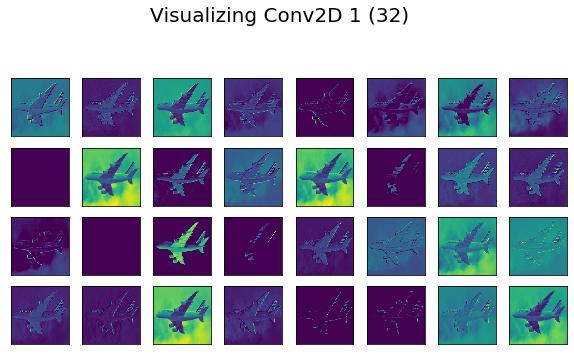

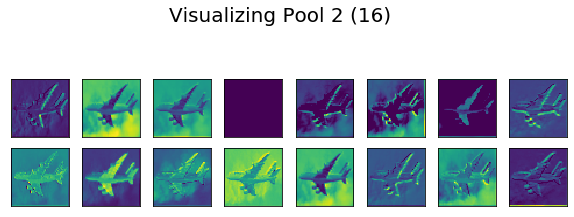

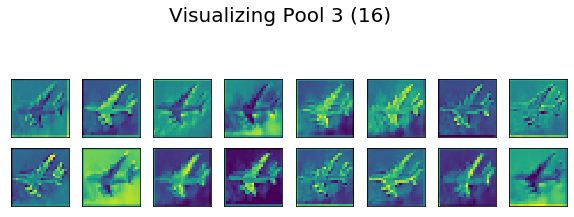

In [21]:
if enable_viz:
    # Creating the feature maps model
    encoder_layer_idx = [1, 4, 6]#[1,2,3,4,5,6]
    encoder_layer_names = ['Conv2D 1 (32)', 'Pool 2 (16)', 'Pool 3 (16)']#['Conv2D 1 (32)', 'Pool 1 (32)', 'Conv2D 2 (16)', 'Pool 2 (16)', 'Conv2D 3 (16)', 'Pool 3 (16)']
    outMaps = [autoencoder.layers[i].output for i in encoder_layer_idx]
    model_fm = Model(inputs=autoencoder.inputs, outputs=outMaps)
    
    def plottingFeatureMaps(img_idx, model):
        test_img = X_train_PP[img_idx]
        test_img = np.expand_dims(test_img, axis=0)
        feature_maps = model.predict(test_img)
        map_cnt = 0
        square = 8
        for fmap in feature_maps:
            num_fmap = (fmap.shape[3])
            ix = 1
            fig = plt.figure(figsize=(10,10))
            fig.suptitle('Visualizing ' + encoder_layer_names[map_cnt], fontsize=20)
            #print('Visualizing ' + encoder_layer_names[map_cnt])
            map_cnt+=1
            for _ in range(int(num_fmap/8)):
                for _ in range(8):
                    ax = plt.subplot(square,square,ix)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    plt.imshow(fmap[0,:,:,ix-1])
                    ix+=1
            plt.show()
    
    # Query image
    plottingFeatureMaps(0, model_fm)

### VISUALIZATION 06: Reconstructed Image from Autoencoder Features

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


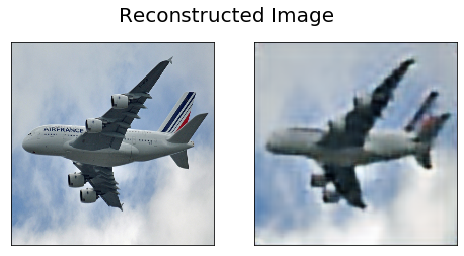

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


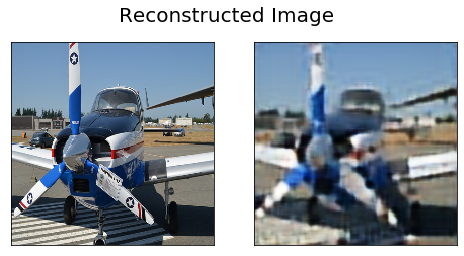

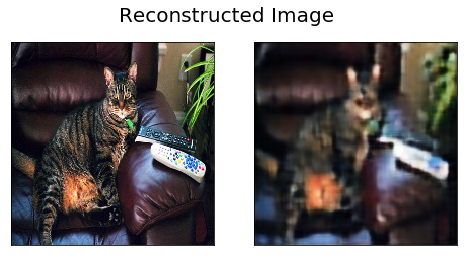

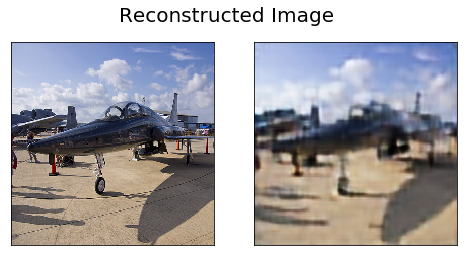

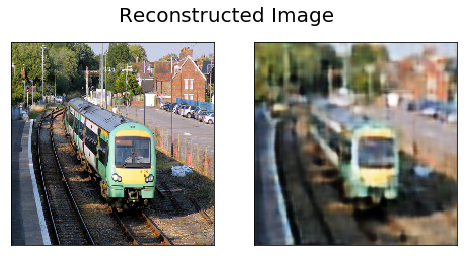

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


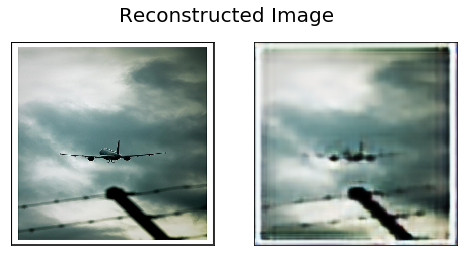

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


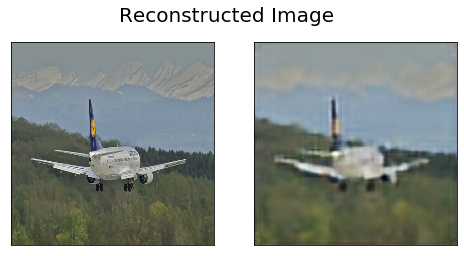

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


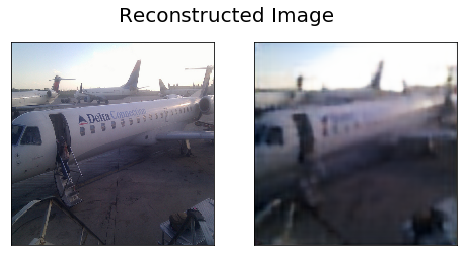

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


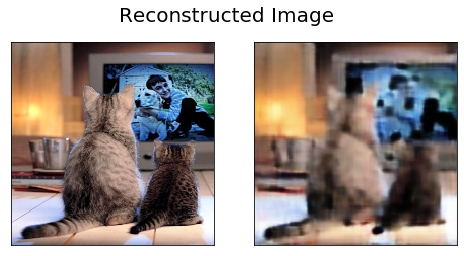

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


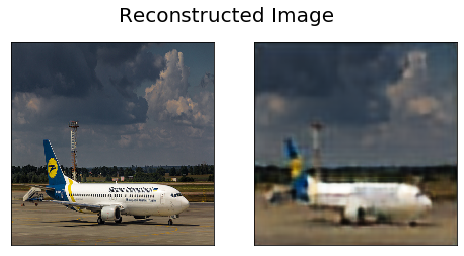

In [22]:
if enable_viz:
    def plottingReconstructionMap(img_idx):
        test_img = X_train_PP[img_idx]
        test_img = cv2.normalize(test_img, test_img,  0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
        reco_img = X_train_reconst[img_idx]
        reco_img = cv2.normalize(reco_img, reco_img,  0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        reco_img = cv2.cvtColor(reco_img, cv2.COLOR_BGR2RGB)
        
        fig = plt.figure(figsize=(8, 4))
        fig.suptitle("Reconstructed Image", fontsize=20)
        ax = plt.subplot(1, 2, 1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(test_img)
        ax = plt.subplot(1, 2, 2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(reco_img)
        plt.show()
    
    #Query Image
    for i in range(10):
        plottingReconstructionMap(i)

## B. SVM - Label Prediction

In [23]:
labels = np.unique(y_train)
# Fit & Predict
classifier = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

### Classification Metrics

In [24]:
# Print classification metrics
print('Confusion Matrix for SVM: ')
print(confusion_matrix(y_test, y_pred, labels=labels))
print('Classification Report for SVM: ')
print(classification_report(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
# print('F1 Score: ', f1_score(y_test, y_pred))

Confusion Matrix for SVM: 
[[109  10   0  32]
 [  4  74   5  24]
 [  2  33   7  32]
 [ 13  12   4 233]]
Classification Report for SVM: 
              precision    recall  f1-score   support

    airplane       0.85      0.72      0.78       151
         cat       0.57      0.69      0.63       107
         dog       0.44      0.09      0.16        74
     vehicle       0.73      0.89      0.80       262

    accuracy                           0.71       594
   macro avg       0.65      0.60      0.59       594
weighted avg       0.69      0.71      0.68       594

Accuracy:  0.7121212121212122


## C. Caption Prediction
### Fit & Predict Nearest Neighbors for each Class

In [25]:
# Fit nearest neighbors for each class
X_train_grouped = dict()
X_train_filenames = dict()
nearest_neighor_models = dict()
for label in labels:
    idx_train = (df_train.loc[df_train['Label'] == label].index)
    nn_classifier = KNeighborsClassifier(n_neighbors=5)
    nn_classifier.fit(X_train[idx_train], [label]*len(idx_train))
    nearest_neighor_models[label] = nn_classifier
    X_train_grouped[label] = [X_train_raw[i] for i in list(idx_train)]
    X_train_filenames[label] = [df_train.loc[i]['Images'] for i in list(idx_train)]

# Predict K nearest images and captions
y_pred_5_filenames = []
img_queries = []
img_retrievals = []
for i, emb_flatten in enumerate(tqdm(X_test, position=0, leave=True)):
    # Find k nearest train neighbours
    _, indices = nearest_neighor_models[y_pred[i]].kneighbors([emb_flatten]) 
    y_pred_5_filenames.append([X_train_filenames[y_pred[i]][idx] for idx in indices.flatten()])
    # Query Image
    img_query = X_test_raw[i]
    img_queries.append(img_query)
    # Retrieval Image
    img_retrieval = [X_train_grouped[y_pred[i]][idx] for idx in indices.flatten()]
    img_retrievals.append(img_retrieval)


100%|████████████████████████████████████████████████████████████████████████████████| 594/594 [00:10<00:00, 58.28it/s]


### Importing Pretrained FastText Embeddings

In [26]:
# Defining the stop words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Importing FastText Embeddings
if True:
    embeddings_model = {}
    for i, line in enumerate(open('models/wiki-news-300d-1M.vec', encoding="utf8")):
        # if i % 1000 == 0:
        #     print(i)
        values = line.split()
        embeddings_model[values[0]] = np.asarray(values[1:], dtype='float32')

### Text Preprocessing Pipeline

In [27]:
# Pipeline to clean each string document from data (product_title, review)
def text_pipeline(s):
    # Normalizing whitespaces
    x = ' '.join(s.split())
    # Lower casing the sentence
    x = x.lower()
    # Remove symbols and numbers
    x = re.sub(r'[^a-zA-Z]+', ' ', x)
    # Tokenize sentences
    x = word_tokenize(x)
    # Remove Stop Words and single character words
    x = list(map(lemmatizer.lemmatize, x))
    # Remove Stop Words and single character words
    x = [w for w in x if w not in stop_words and len(w) != 1]
    return x


### Caption Processing Functions

In [28]:
def get_cosine_distance(t1, t2):
    vector_1 = np.mean([embeddings_model[word] for word in t1 if word in embeddings_model],axis=0)
    vector_2 = np.mean([embeddings_model[word] for word in t2 if word in embeddings_model],axis=0)
    cosine_sim = cosine(vector_1, vector_2)
    return (1-cosine_sim)


def get_caption(text, caps):
    sum_sim_all = []
    if len(caps)>25:
        caps = caps[:25]
        text = text[:25]
    for i in range(len(caps)):
        sum_sim = 0
        for j in range(len(caps)):
            if i!=j:
                sum_sim += (get_cosine_distance(caps[i], caps[j]))
        sum_sim_all.append(sum_sim/len(caps))
        cap_id = sum_sim_all.index(max(sum_sim_all))
        return [text[cap_id], caps[cap_id]]

def get_caption_similarity_with_true_cap(true_text, true_caps, pred_cap):
    sims = []
    for caps in true_caps:
        sims.append(get_cosine_distance(caps, pred_cap))
    max_cap_id = sims.index(max(sims))
    return true_text[max_cap_id], '%.4f' % sims[max_cap_id]

def filter_tags(tags, k):
    tag_counts = defaultdict(int)
    for i in tags:
        tag_counts[i]+=1
    tag_count_list = list(tag_counts.items())
    tag_count_list.sort(key=lambda x: x[1], reverse=True)
    if k != 'all':
        top_tags = tag_count_list[:k]
        return ', '.join(list(map(lambda x: x[0], top_tags)))
    else:
        return tag_count_list, tag_counts

### Generate Captions

In [29]:
# Dataframe for train caption processing
X_train_caps = pd.DataFrame(df_train_cap['Images'])
X_train_caps['Text'] = df_train_cap['Text']
X_train_caps['Tokens'] = df_train_cap['Text'].apply(text_pipeline)
X_train_caps['Images'] = df_train_cap['Images'].apply(lambda x: x.split('#')[0])
# Dataframe for test caption processing
X_test_caps = pd.DataFrame(df_test_cap['Images'])
X_test_caps['Text'] = df_test_cap['Text']
X_test_caps['Tokens'] = df_test_cap['Text'].apply(text_pipeline)
X_test_caps['Images'] = df_test_cap['Images'].apply(lambda x: x.split('#')[0])

# Generating Captions
y_pred_caps = [] # pred_cap, true_cap, score
y_pred_tags = []
for idx in tqdm(range(len(y_pred_5_filenames)), position=0, leave=True):
    # Generating best caption from train
    files = y_pred_5_filenames[idx]
    caps_filt = X_train_caps[X_train_caps['Images'].isin(files[0:3])]
    tags_filt = X_train_caps[X_train_caps['Images'].isin(files[0:3])]
    caps_gen_text, caps_gen_toks = get_caption(list(caps_filt['Text']), list(caps_filt['Tokens']))
    
    # Finding most similar test caption with gen caption
    test_f_id = df_test['Images'][idx]
    test_caps = X_test_caps[X_test_caps['Images'].isin([test_f_id])]
    
    cap_sim_txt, cap_sim_scr = get_caption_similarity_with_true_cap(list(test_caps['Text']), list(test_caps['Tokens']), caps_gen_toks)
    y_pred_caps.append([caps_gen_text, cap_sim_txt, cap_sim_scr])
    y_pred_tags.append([inr for outr in  list(tags_filt['Tokens']) for inr in outr])

100%|███████████████████████████████████████████████████████████████████████████████| 594/594 [00:04<00:00, 140.63it/s]


### VISUALIZATION 07: Plotting Predicted Images & Caption for Test Set

In [157]:
# Function to plot the recommended images
def plot_nearest_images(img_query, imgs_retrieval, outFile, cap, tags, id_x):
    n_retrieval = len(imgs_retrieval)+1
    fig = plt.figure(figsize=(2.5*n_retrieval, 3))
    fig.suptitle("Test Results "+str(id_x), fontsize=20)
    # Plot query image
    ax = plt.subplot(1, n_retrieval, 1)
    img_query = cv2.resize(img_query, image_dims[:2])
    img_query = cv2.cvtColor(img_query, cv2.COLOR_BGR2RGB)
    plt.imshow(img_query)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(3)
        ax.spines[axis].set_color('red')
    ax.set_title("Test Image",  fontsize=10)

    # Plot retrieval images
    for i, img_res in enumerate(imgs_retrieval):
        ax = plt.subplot(1, n_retrieval, i + 2)
        img_res = cv2.resize(img_res, image_dims[:2])
        img_res = cv2.cvtColor(img_res, cv2.COLOR_BGR2RGB)
        plt.imshow(img_res)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)
            ax.spines[axis].set_color('blue')
        ax.set_title("NN #%d" % (i+1), fontsize=10)
    plt.annotate('Predicted Tags: '+tags, (0,0), (-715, -10), xycoords='axes fraction', 
                 textcoords='offset points', va='top',
                 bbox=dict(fill=False, edgecolor='black', linewidth=1), size=10)
    plt.annotate('Predicted Caption: '+cap[0], (0,0), (-715, -30), xycoords='axes fraction', 
                 textcoords='offset points', va='top',
                 bbox=dict(fill=False, edgecolor='black', linewidth=1), size=10)
    plt.annotate('True Caption: '+cap[1], (0,0), (-715, -50), xycoords='axes fraction', 
                 textcoords='offset points', va='top',
                 bbox=dict(fill=False, edgecolor='black', linewidth=1), size=10)
    plt.annotate('Cosine Score: '+cap[2], (0,0), (-715, -70), xycoords='axes fraction', 
                 textcoords='offset points', va='top',
                 bbox=dict(fill=False, edgecolor='black', linewidth=1), size=10)
    if outFile is None:
        #plt.show()
        pass
    else:
        plt.savefig(outFile, bbox_inches='tight')
        plt.show()
    plt.close()

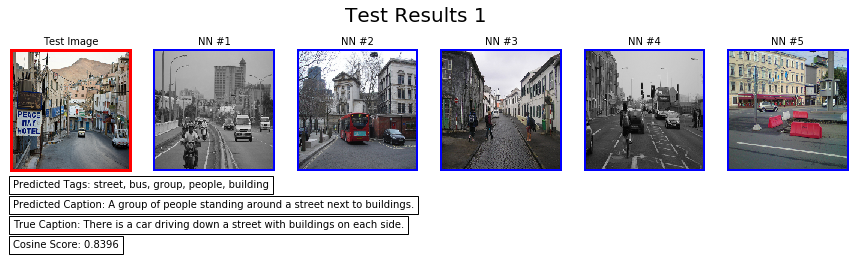

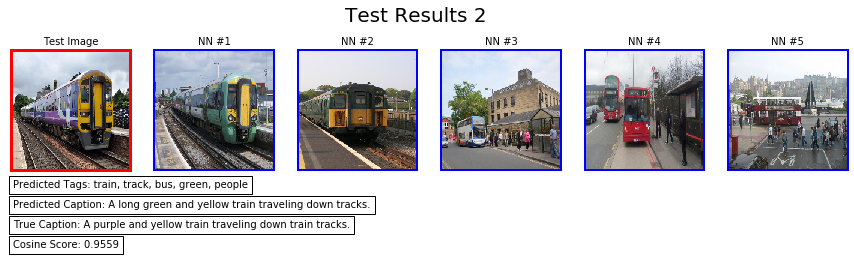

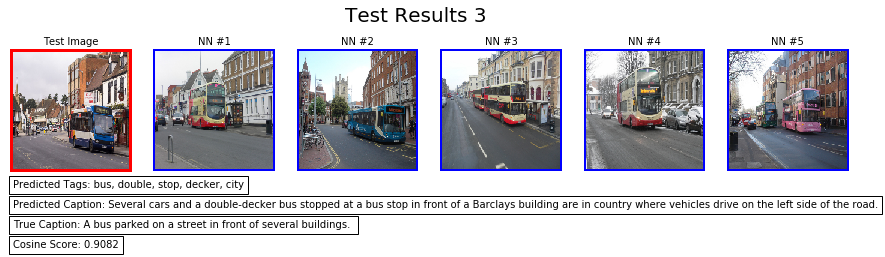

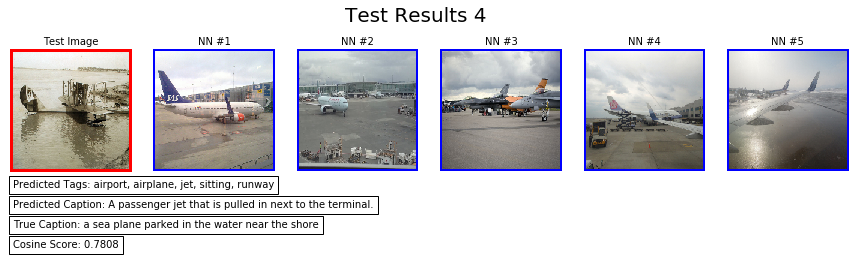

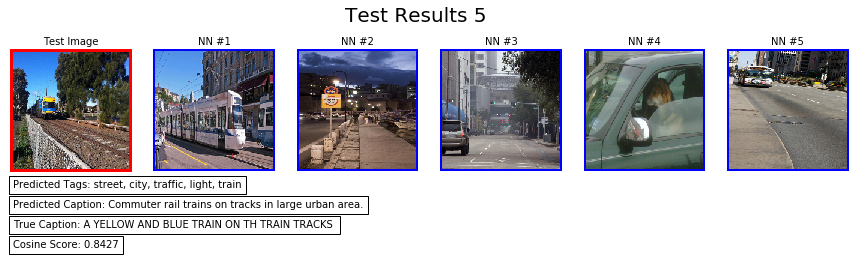

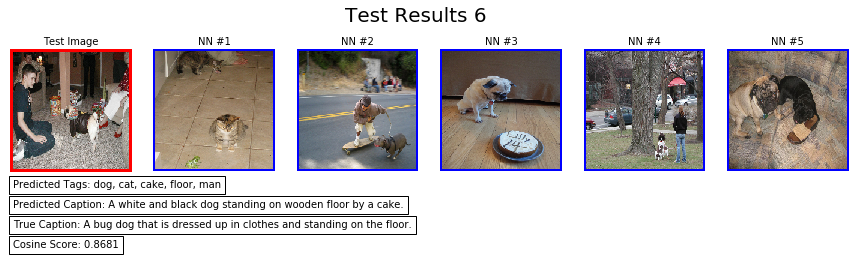

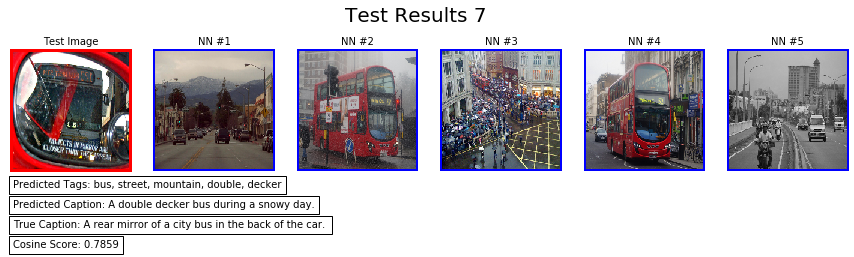

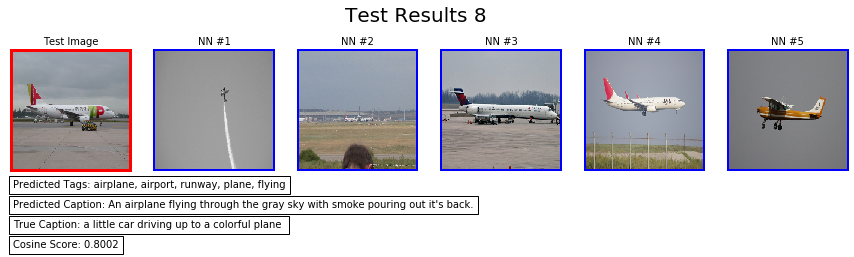

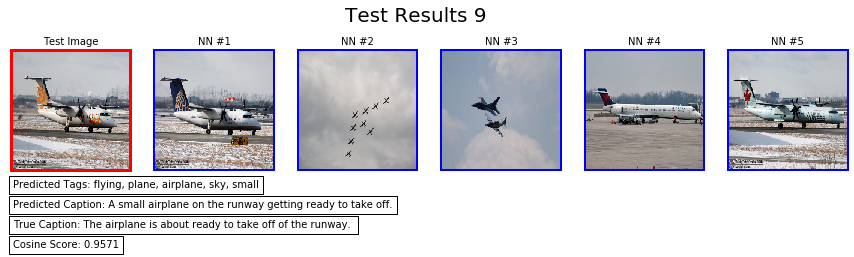

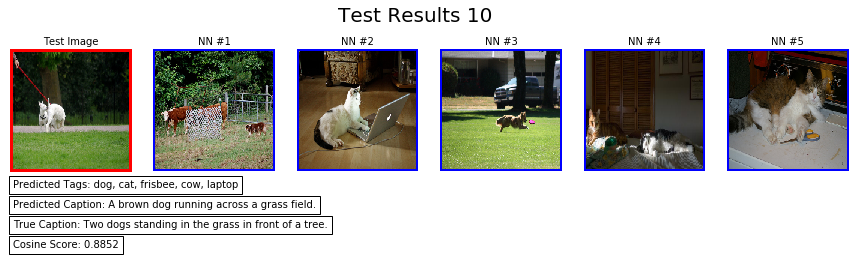

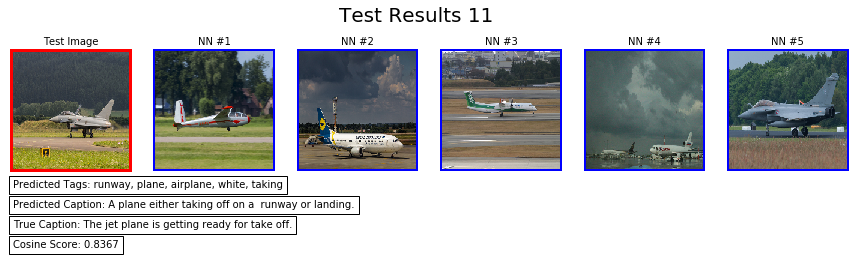

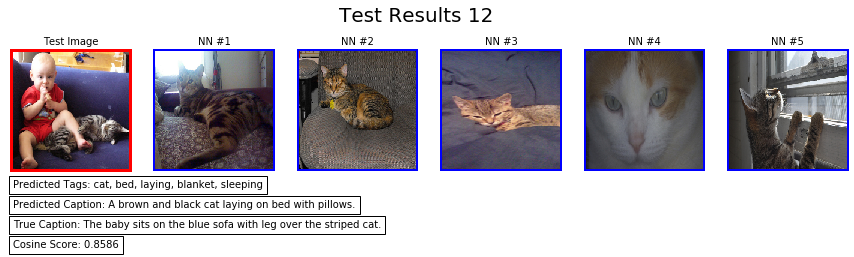

In [158]:
examples = [0,2,4,5,7,38,9,19,21,309,30,48] # range(len(y_pred_caps))
if enable_viz:
    plot_res_count = 0 # Select 0 for ALL plots
    if plot_res_count == 0:
        plot_res_count = len(X_test)
    plt_counter = 0
    for i in examples:
        outFile = os.path.join(images_output, "{}_results.png".format(list(df_test['Images'])[i][:-4]))
        # Plot the similar images
        if plt_counter<plot_res_count:
            plot_nearest_images(img_queries[i], img_retrievals[i], outFile, y_pred_caps[i], filter_tags(y_pred_tags[i], 5), examples.index(i)+1)
            plt_counter+=1

### VISUALIZATION 08: Word Distribution for Individual Test Images

In [137]:
def countWordPlot(source, x_val, y_val, category):
    files = list(np.unique(source[y_val]))
    categories = list(np.unique(source[category]))
    color_scale = alt.Scale(domain=categories)
    base = alt.Chart(source).mark_circle().encode(
        x=x_val,
        y='count('+x_val+')',
        size='count('+x_val+')',
        color=alt.Color(category+':N', scale=color_scale),
        tooltip=[x_val]
    ).interactive()


    # A dropdown filter
    img_dropdown = alt.binding_select(options=files)
    img_select = alt.selection_single(fields=[y_val], bind=img_dropdown, name="Test")

    filter_imgs = base.add_selection(
        img_select
    ).transform_filter(
        img_select
    ).properties(title="Word Distribution of Predicted Captions", width=800, height=300 )
    return filter_imgs

In [138]:
# Aggregating tags by test image
image_wise_tags=[]
for i in examples:
    for j in y_pred_tags[i]:
        label = y_pred[i]
        image_wise_tags.append([j, examples.index(i)+1, label])
image_wise_tags_DF = pd.DataFrame(image_wise_tags, columns=['Word', 'Image', 'Category'])

In [139]:
if enable_viz:
    display(countWordPlot(image_wise_tags_DF, 'Word', 'Image', 'Category'))

alt.Chart(...)

### VISUALIZATION 09: Class Distribution of Words

In [130]:
def category_word_dist(source, word, category, count):
    selector = alt.selection_single(empty='all', fields=[word])
    color_scale = alt.Scale(domain=list(np.unique(source[category])))
    base = alt.Chart(source).add_selection(selector)

    points = base.mark_circle().encode(
        x=word+':O',
        y='sum('+count+'):Q',
        size='sum('+count+'):Q',
        tooltip=[word, count]
    ).properties(
        width=800,
        height=300
    )

    hists = base.mark_bar(opacity=0.8, thickness=100).encode(
        y=alt.Y(category+':O'),
        x=alt.X(count,
                stack=None,
                scale=alt.Scale()),
        color=alt.Color(category+':N',
                        scale=color_scale)
    ).transform_filter(
        selector
    ).properties(
        width=800
    )
    return points & hists

In [131]:
# Aggregating words by class
all_tags=defaultdict(int)
for i in range(len(y_pred_tags)):
    label = y_train[i]
    if label == y_pred[i]:
        for j in y_pred_tags[i]:
            all_tags[(j, label)]+=1
all_tags = list(all_tags.items())
all_tags.sort(key=lambda x:x[1], reverse=True)
all_tags = list(map(lambda x:[x[0][0], x[0][1], x[1]], all_tags))
all_tags = pd.DataFrame(all_tags, columns=['Word', 'Category', 'Count'])

In [132]:
if enable_viz:
    display(category_word_dist(all_tags, 'Word', 'Category', 'Count'))

alt.VConcatChart(...)

### VISUALIZATION 10: Word Distribution of Class

In [192]:
def catCountWordPlot(source, x_val, y_val, category):
    categories = list(np.unique(source[category]))
    color_scale = alt.Scale(domain=categories)
    base = alt.Chart(source).mark_circle().encode(
        x=alt.X(x_val,
                stack=None,
                scale=alt.Scale(),
                axis=alt.Axis(labelOverlap=True)),
        y='sum('+y_val+')',
        size='sum('+y_val+')',
        color=alt.Color(category+':N', scale=color_scale),
        tooltip=[x_val]
    ).interactive()


    # A dropdown filter
    img_dropdown = alt.binding_select(options=categories)
    img_select = alt.selection_single(fields=[category], bind=img_dropdown, name="Category")

    filter_imgs = base.add_selection(
        img_select
    ).transform_filter(
        img_select
    ).properties(title="Word Distribution of Predicted Captions", width=800, height=300 )
    return filter_imgs

In [193]:
if enable_viz:
    display(catCountWordPlot(all_tags, 'Word', 'Count', 'Category'))

alt.Chart(...)